In [1]:
import pandas as pd
pd.set_option('display.max_columns', 299)

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
%matplotlib inline

import re, os, sys
import seaborn as sns
import emoji
import numpy as np
import lda
from pprint import pprint

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_notebook, save,output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_file, show
from bokeh.layouts import row,column
from bokeh.models import Title
output_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

ModuleNotFoundError: No module named 'spacy'

### Q1: Preprocessing, Exploratory Data Analysis and Part-of-Speech Tagging

#### IMDB Dataset

#### Exploratory Data Analysis:

- Sentiment Distribution: The dataset consists of 12,500 positive sentiment reviews (labeled as 1) and 12,500 negative sentiment reviews (labeled as 0). The distribution is balanced, indicating an equal representation of positive and negative sentiments.
- Number of Reviews: The dataset contains a total of 25,000 reviews. This information helps us understand the size of the dataset.
- Average Review Length (in words): The average length of the reviews, measured in terms of the number of words, is approximately 233.7872. This metric gives an idea of the typical length of the reviews in the dataset.
- Number of Unique Words: The dataset contains 280,617 unique words. This count indicates the diversity of vocabulary used in the reviews.

#### The pre-processing steps in the provided code can be summarized as follows:

- Tokenization: The input text is split into sentences using the sent_tokenize function from NLTK and stored in the tokenized variable.
- Stopword Removal: Stop words, which are commonly occurring words with little semantic meaning, are removed from the tokenized sentences using the NLTK stopwords corpus.
- Part-of-Speech (POS) Tagging: Each word in the tokenized sentences is assigned a part-of-speech tag using the nltk.pos_tag function. Only words with specific tags (adjectives, nouns, and verbs) are selected and stored in the newstring1 list.
- Data Cleaning: The text is further cleaned by removing non-alphabetic characters, converting all text to lowercase, removing stop words again (if any were missed earlier), removing short words (less than 3 characters), removing slashes ("/"), and removing extra whitespaces.
- Lemmatization: The cleaned text is lemmatized using the SpaCy library. Lemmatization reduces words to their base or dictionary form to consolidate semantically similar words.

#### The importance of POS tagging in NLP:

- Improved Word Sense Disambiguation: POS tagging helps in disambiguating words with multiple meanings based on their grammatical role in the sentence. This aids in understanding the correct sense of a word in a given context.
- Syntactic and Semantic Analysis: POS tags provide information about the syntactic structure of a sentence, such as identifying nouns, verbs, adjectives, and their relationships. This information is crucial for various NLP tasks like parsing, information extraction, and machine translation.
- Feature Extraction: POS tags can be used as features for training machine learning models in tasks such as sentiment analysis, named entity recognition, and text classification. They capture grammatical patterns and can help improve the accuracy of these models.
- Language Understanding: POS tagging is a fundamental step towards understanding the grammatical structure and meaning of sentences. It forms the basis for higher-level language processing tasks, such as semantic role labeling and text generation.
- Text Normalization: POS tags aid in text normalization tasks by identifying inflected forms of words and mapping them to their base forms. This helps in reducing vocabulary size, improving information retrieval, and achieving better text representation.

In [2]:
# Specify the path to the dataset folder
dataset_path = 'aclImdb/train/'

# Load the reviews into a DataFrame
reviews = []
sentiments = []

for sentiment, folder in enumerate(['neg', 'pos']):
    folder_path = os.path.join(dataset_path, folder)
    files = os.listdir(folder_path)
    for file in files:
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            review = f.read()
        reviews.append(review)
        sentiments.append(sentiment)

# Create the DataFrame
df = pd.DataFrame({'Review': reviews, 'Sentiment': sentiments})

# Shuffle the DataFrame
df = shuffle(df)

# Reset the index of the shuffled DataFrame
df = df.reset_index(drop=True)

# Display the shuffled DataFrame
df.head()

,Review,Sentiment
0,If Mulder was looking for his real father here...,1
1,Iam a Big fan of Mr Ram Gopal Varma but i coul...,0
2,Just the ultimate masterpiece in my opinion. E...,1
3,"Set in South Africa, a young black guy tries t...",0
4,this film is in the MANDINGO & DRUM type<br />...,0


In [3]:
# Sentiment Distribution
sentiment_counts = df['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

# Number of Reviews
num_reviews = len(df)
print("\nNumber of Reviews:", num_reviews)

# Average Review Length
df['Review_Length'] = df['Review'].apply(lambda x: len(x.split()))
avg_review_length = df['Review_Length'].mean()
print("Average Review Length (in words):", avg_review_length)

# Unique Words
unique_words = set(" ".join(df['Review']).split())
num_unique_words = len(unique_words)
print("Number of Unique Words:", num_unique_words)

Sentiment Distribution:
1    12500
0    12500
Name: Sentiment, dtype: int64

Number of Reviews: 25000
Average Review Length (in words): 233.7872
Number of Unique Words: 280617


In [4]:
stop_words = set(stopwords.words('english'))

def process_text(data):
    data.columns = ['Comments']
    data['Comments'] = data['Comments'].astype(str)
    docs = data
    docs['id'] = docs.index
    docs1 = list(docs.loc[:, 'Comments'].astype(str))
    tags = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    final_doc = []

    # Tokenize
    for j in range(len(docs)):
        tokenized = sent_tokenize(docs1[j])
        res = "".join(tokenized)
        tokenized = [res]

        for i in tokenized:
            wordsList = nltk.word_tokenize(i)
            wordsList = [w for w in wordsList if not w in stop_words]
            tagged = nltk.pos_tag(wordsList)
            newstring1 = []
            newstring1 = [x[0] for x in tagged if x[1] in tags]  # POS tagging
            final_doc.append(' '.join(newstring1))

    df = pd.DataFrame([(final_doc)])
    docs1 = df.T
    docs1.columns = ['Comments']
    docs1 = docs1['Comments'].astype(str)

    lang = list(docs1.astype(str))
    new_df = pd.DataFrame(lang)
    new_df['id'] = new_df.index
    new_df['original'] = list(docs['Comments'])

    # Data Cleaning
    new_df['cleaned'] = [re.sub("[^a-zA-Z\s+]", "", i) for i in new_df.iloc[:, 0]]
    new_df['cleaned'] = [x.lower() for x in list(new_df.loc[:, 'cleaned'])]
    new_df.loc[:, 'cleaned'] = [w if not w in stop_words else "None" for w in list(new_df.loc[:, 'cleaned'])]
    new_df.loc[:, 'cleaned'] = [t if len(t) > 2 else "None" for t in new_df.loc[:, 'cleaned']]
    new_df['cleaned'] = [re.sub("/", "", sent) for sent in list(new_df.loc[:, 'cleaned'])]
    new_df['cleaned'] = [re.sub('\s+', ' ', sent) for sent in list(new_df.loc[:, 'cleaned'])]
    new_df['cleaned'] = [sent.strip() for sent in list(new_df.loc[:, 'cleaned'])]

    # Lemmatization
    spacy_nlp = spacy.load('en_core_web_sm')
    lang = list(new_df['cleaned'])
    list1 = []
    for sent in lang:
        doc = spacy_nlp(sent)
        tokens = [token.text for token in doc]
        string = ""
        for token in doc:
            if token.lemma_ == "-PRON-":  # != token.lemma_:
                string += token.text
                string += " "
            else:
                string += token.lemma_
                string += " "
        list1.append(string)

    new_df['modified'] = list1
    new_df['modified'] = new_df['modified'].astype(str).str.strip()

    return new_df[['original', 'modified']]

In [5]:
processed_df = process_text(df[['Review']])
processed_df

/var/folders/6g/cbm28m0d2hl52mwmdpkqcgq00000gn/T/ipykernel_43717/2878779492.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Comments'] = data['Comments'].astype(str)
/var/folders/6g/cbm28m0d2hl52mwmdpkqcgq00000gn/T/ipykernel_43717/2878779492.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['id'] = docs.index


,original,modified
0,If Mulder was looking for his real father here...,mulder look real father darren mcgavin x file ...
1,Iam a Big fan of Mr Ram Gopal Varma but i coul...,iam big fan mr ram gopal varma believe make mo...
2,Just the ultimate masterpiece in my opinion. E...,ultimate masterpiece line phrase picture place...
3,"Set in South Africa, a young black guy tries t...",set south africa young black guy try land part...
4,this film is in the MANDINGO & DRUM type<br />...,film mandingo drum type br br dreadful but wel...
...,...,...
24995,Absolutely horrific film. Ameteurish and it is...,horrific filmameteurish funny alllead characte...
24996,I'm going to keep this review short and sweet....,m go keep review short sweet br br see trailer...
24997,"please, future writers, producers, directors -...",please future writer producer director learn m...
24998,I was pretty young when this came out in the U...,young come we record tv watch whole thing memo...


In [6]:
df_final = pd.concat([processed_df, df[['Sentiment']]],axis=1)
df_final

,original,modified,Sentiment
0,If Mulder was looking for his real father here...,mulder look real father darren mcgavin x file ...,1
1,Iam a Big fan of Mr Ram Gopal Varma but i coul...,iam big fan mr ram gopal varma believe make mo...,0
2,Just the ultimate masterpiece in my opinion. E...,ultimate masterpiece line phrase picture place...,1
3,"Set in South Africa, a young black guy tries t...",set south africa young black guy try land part...,0
4,this film is in the MANDINGO & DRUM type<br />...,film mandingo drum type br br dreadful but wel...,0
...,...,...,...
24995,Absolutely horrific film. Ameteurish and it is...,horrific filmameteurish funny alllead characte...,0
24996,I'm going to keep this review short and sweet....,m go keep review short sweet br br see trailer...,1
24997,"please, future writers, producers, directors -...",please future writer producer director learn m...,1
24998,I was pretty young when this came out in the U...,young come we record tv watch whole thing memo...,1


In [ ]:
# Specify the path to the dataset folder
dataset_path = 'aclImdb/test/'

# Load the reviews into a DataFrame
reviews = []
sentiments = []

for sentiment, folder in enumerate(['neg', 'pos']):
    folder_path = os.path.join(dataset_path, folder)
    files = os.listdir(folder_path)
    for file in files:
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            review = f.read()
        reviews.append(review)
        sentiments.append(sentiment)

# Create the DataFrame
df_test = pd.DataFrame({'Review': reviews, 'Sentiment': sentiments})

# Shuffle the DataFrame
df_test = shuffle(df_test)

# Reset the index of the shuffled DataFrame
df_test = df_test.reset_index(drop=True)

# Display the shuffled DataFrame
df_test.head()

,Review,Sentiment
0,This film is right up there with The Oscar and...,0
1,Why didn't critics like this movie?? I don't g...,1
2,The film is visually stunning: from the dusty ...,0
3,Rosie Perez is the lead in this very engaging ...,1
4,"""Challenge to be Free"" was one of the first fi...",1


#### Twitter Dataset

#### Exploratory Data Analysis

- The dataset contains 6838 samples with emotions labeled for each tweet.
- Summary statistics show the mean and standard deviation for each emotion category (anger, anticipation, disgust, fear, joy, love, optimism, pessimism, sadness, surprise, trust).
- The emotions distribution indicates the number of occurrences for each emotion category in the dataset.
- The average number of unique words in the tweets is 16.063, and the maximum number of unique words is 22.
- The average review length in tweets is 16.063 characters.

##### Key points to note:

- The dataset has a slightly higher representation of disgust and joy emotions compared to other emotions like anticipation, love, pessimism, surprise, and trust.
- The average tweet length is relatively short, with an average of 16 characters, indicating concise expressions.
- The number of unique words varies across tweets, with some containing as few as 6 unique words and others having up to 22 unique words.

#### Data Preprocessing

- Remove Handles: The function remove_handles() removes Twitter handles (user mentions starting with '@') from each tweet in the dataset. It uses regular expressions to substitute the handles with an empty string.
- Process Text Tweet: The function process_text_tweet() takes the input data, applies various text processing steps, and returns a new DataFrame with the original and modified text.
- Tokenization: It tokenizes the tweet text into sentences using the sent_tokenize() function from NLTK. Since there's only one row in the given example DataFrame, the result is a single-element list containing the tokenized text.
- Remove URLs: It uses regular expressions to remove URLs from the tokenized text.
- Remove Hashtags (Optional): If there are any hashtags present in the tokenized text, they are removed.
- Remove Emojis: The emoji.demojize() function from the emoji library converts emojis into textual representations.
- Remove Punctuation: It uses regular expressions to remove punctuation from the tokenized text.
- Data Cleaning: The text is converted to lowercase, and stop words (commonly used words like "the," "is," "and," etc.) are removed. Words with fewer than three characters are also removed.- 
- Lemmatization: It uses spaCy's English language model (en_core_web_sm) to lemmatize the words, which means converting words to their base form (e.g., "running" to "run," "better" to "good").
- Return Result: The function returns a new DataFrame containing the original and modified text (after preprocessing and lemmatization).

In [46]:
df_tweet = pd.read_csv("SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt", sep = '\t')
df_tweet

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,2017-En-21383,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0
6834,2017-En-41441,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0
6835,2017-En-10886,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0
6836,2017-En-40662,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0



Summary Statistics:
             anger  anticipation      disgust         fear          joy  \
count  6838.000000   6838.000000  6838.000000  6838.000000  6838.000000   
mean      0.372039      0.143024     0.380521     0.181632     0.362240   
std       0.483384      0.350123     0.485550     0.385569     0.480683   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       0.000000      0.000000     0.000000     0.000000     0.000000   
75%       1.000000      0.000000     1.000000     0.000000     1.000000   
max       1.000000      1.000000     1.000000     1.000000     1.000000   

              love     optimism    pessimism      sadness     surprise  \
count  6838.000000  6838.000000  6838.000000  6838.000000  6838.000000   
mean      0.102369     0.290143     0.116262     0.293653     0.052793   
std       0.303155     0.453862     0.320562     0.455468     0.223637   
min    

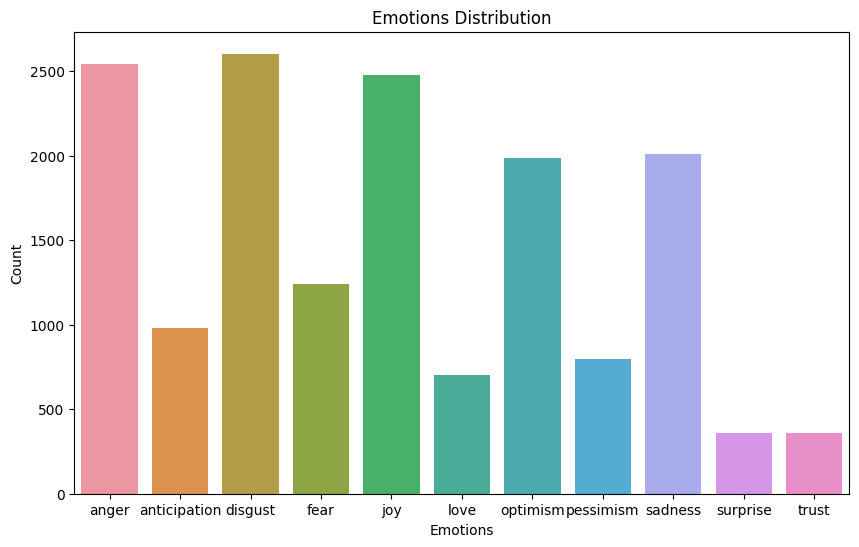

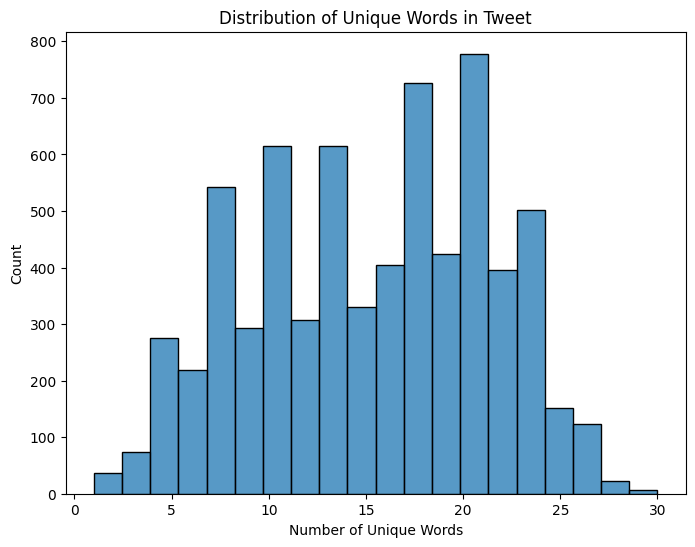

In [47]:
# Check the summary statistics of the DataFrame
print("\nSummary Statistics:")
print(df_tweet.describe())

# Check the distribution of emotions
emotions_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
emotions_distribution = df_tweet[emotions_cols].sum()
print("\nEmotions Distribution:")
print(emotions_distribution)

# Calculate the number of unique words in the Tweet column
df_tweet['Num_Unique_Words'] = df_tweet['Tweet'].apply(lambda x: len(set(x.split())))
num_unique_words = df_tweet['Num_Unique_Words']
print("\nNumber of Unique Words in Tweet:", num_unique_words)

# Calculate the average review length in the Tweet column
df_tweet['Review_Length'] = df_tweet['Tweet'].apply(lambda x: len(x.split()))
average_review_length = df_tweet['Review_Length'].mean()
print("Average Review Length in Tweet:", average_review_length)

# Visualize the distribution of emotions using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions_cols, y=emotions_distribution)
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotions Distribution")
plt.show()

# Visualize the distribution of unique words in Tweet using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_tweet['Num_Unique_Words'], bins=20)
plt.xlabel("Number of Unique Words")
plt.ylabel("Count")
plt.title("Distribution of Unique Words in Tweet")
plt.show()

In [14]:
stop_words = set(stopwords.words('english'))

def remove_handles(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        cleaned_tweet = re.sub(r'@\w+\s*', '', tweet)
        cleaned_tweets.append(cleaned_tweet)
    return cleaned_tweets

def process_text_tweet(data):
    data.columns = ['Comments']
    data['Comments'] = data['Comments'].astype(str)
    docs = data
    docs['id'] = docs.index
    docs1 = list(docs.loc[:, 'Comments'].astype(str))
    # print(docs1)
    docs1 = remove_handles(docs1)
    tags = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    final_doc = []

    # Tokenize
    for j in range(len(docs)):
        tokenized = sent_tokenize(docs1[j])
        res = "".join(tokenized)
        tokenized = [res]

        for i in tokenized:
            wordsList = nltk.word_tokenize(i)
            wordsList = [w for w in wordsList if not w in stop_words]

            # Additional preprocessing steps
            # Remove Twitter Handles
            wordsList = [re.sub(r'@\w+', '', w) if not w.startswith('@') else '' for w in wordsList]  # Modified regex pattern

            # Remove URLs
            wordsList = [re.sub(r'http\S+|www\S+', '', w) for w in wordsList]

            # Remove Hashtags (optional)
            wordsList = [w for w in wordsList if not w.startswith('#')]

            # Remove Emojis or replace with textual representations
            wordsList = [emoji.demojize(w) for w in wordsList]

            # Remove Punctuation
            wordsList = [re.sub(r'[^\w\s]', '', w) for w in wordsList]

            tagged = nltk.pos_tag(wordsList)
            newstring1 = []
            newstring1 = [x[0] for x in tagged if x[1] in tags]  # POS tagging
            final_doc.append(' '.join(newstring1))

    df = pd.DataFrame([(final_doc)])
    docs1 = df.T
    docs1.columns = ['Comments']
    docs1 = docs1['Comments'].astype(str)

    lang = list(docs1.astype(str))
    new_df = pd.DataFrame(lang)
    new_df['id'] = new_df.index
    new_df['original'] = list(docs['Comments'])

    # Data Cleaning
    new_df['cleaned'] = [re.sub("[^a-zA-Z\s+]", "", i) for i in new_df.iloc[:, 0]]
    new_df['cleaned'] = [x.lower() for x in list(new_df.loc[:, 'cleaned'])]
    new_df.loc[:, 'cleaned'] = [w if not w in stop_words else "None" for w in list(new_df.loc[:, 'cleaned'])]
    new_df.loc[:, 'cleaned'] = [t if len(t) > 2 else "None" for t in new_df.loc[:, 'cleaned']]
    new_df['cleaned'] = [re.sub("/", "", sent) for sent in list(new_df.loc[:, 'cleaned'])]
    new_df['cleaned'] = [re.sub('\s+', ' ', sent) for sent in list(new_df.loc[:, 'cleaned'])]
    new_df['cleaned'] = [sent.strip() for sent in list(new_df.loc[:, 'cleaned'])]

    # Lemmatization
    spacy_nlp = spacy.load('en_core_web_sm')
    lang = list(new_df['cleaned'])
    list1 = []
    for sent in lang:
        doc = spacy_nlp(sent)
        tokens = [token.text for token in doc]
        string = ""
        for token in doc:
            if token.lemma_ == "-PRON-":  # != token.lemma_:
                string += token.text
                string += " "
            else:
                string += token.lemma_
                string += " "
        list1.append(string)

    new_df['modified'] = list1
    new_df['modified'] = new_df['modified'].astype(str).str.strip()

    return new_df[['original', 'modified']]


In [15]:
df_result1 = process_text_tweet(df_tweet[['Tweet']])
df_result1

/var/folders/6g/cbm28m0d2hl52mwmdpkqcgq00000gn/T/ipykernel_43717/4169776403.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Comments'] = data['Comments'].astype(str)
/var/folders/6g/cbm28m0d2hl52mwmdpkqcgq00000gn/T/ipykernel_43717/4169776403.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['id'] = docs.index


,original,modified
0,“Worry is a down payment on a problem you may ...,worry payment problem havejoyce meyer motivati...
1,Whatever you decide to do make sure it makes y...,make sure make happy
2,@Max_Kellerman it also helps that the majorit...,help majority nfl coach ineptsome bill obrien ...
3,Accept the challenges so that you can literall...,accept challenge feel exhilaration victory geo...
4,My roommate: it's okay that we can't spell bec...,roommate s okay nt spell autocorrect terrible ...
...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,hi work towards highlighted concern keep post ...
6834,@andreamitchell said @berniesanders not only d...,say play hrc campaign oh discourage party vote...
6835,@isthataspider @dhodgs i will fight this guy! ...,fight guy do insult lion kinda arewaste good p...
6836,i wonder how a guy can broke his penis while h...,wonder guy break penis sex serious


In [26]:
df_tweet_final = pd.concat([df_result1,df_tweet[['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']]],axis=1)
df_tweet_final

,original,modified,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,worry payment problem havejoyce meyer motivati...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,make sure make happy,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,help majority nfl coach ineptsome bill obrien ...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,accept challenge feel exhilaration victory geo...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,roommate s okay nt spell autocorrect terrible ...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,hi work towards highlighted concern keep post ...,0,0,0,0,0,0,0,0,0,0,0
6834,@andreamitchell said @berniesanders not only d...,say play hrc campaigning oh discourage party v...,0,1,0,0,0,0,0,0,0,1,0
6835,@isthataspider @dhodgs i will fight this guy! ...,fight guy do insult lion kinda arewaste good p...,1,0,1,0,0,0,0,1,0,0,0
6836,i wonder how a guy can broke his penis while h...,wonder guy break penis sex serious,0,0,0,0,0,0,0,0,0,1,0


In [40]:
df_tweet_final = pd.concat([df_result1,df_result[['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']]],axis=1)
df_tweet_final

,original,modified,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,.\nWe express our deep concern about the suspe...,deep concern suspension nplease reactivate ith...,1,0,1,1,0,0,0,0,0,1,0
1,@IndigoHawthorne Then u understand that rage i...,u understand rage control rational visceralnot...,1,0,1,0,0,0,0,0,0,0,0
2,@Sophiejulia @CalebAtChipotle @calebpressleyxo...,relentless pipe shelter,0,0,0,0,0,0,0,0,0,0,0
3,@UNHumanRights @UNDP_Pakistan wat an irony? #P...,wat irony pakistan lecture world curb,1,0,1,0,0,0,0,0,0,0,0
4,@rizikxo @estherolo_ @Corinnetuc17 @ING Her re...,reasoning,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,Connivers blind to existential fury,conniver blind existential fury,1,0,1,0,0,0,0,0,0,0,0
7720,"the grave of a beat, a bravehearted cave lover...",grave beat bravehearte cave lover cage lover s...,0,1,0,0,1,0,1,0,0,0,0
7721,A few things that scare me thunder needles cat...,thing scare thunder needle cat creepy dolls he...,0,0,0,1,0,0,0,0,0,0,0
7722,"says, who are you to compared me with the othe...",say compare other m human lit fire,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df_tweet_test = pd.read_csv("/content/drive/MyDrive/Movie_review/2018-E-c-En-test-gold.txt", sep = '\t')
df_tweet_test

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-En-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1
1,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0
2,2018-En-00385,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0
3,2018-En-03001,This time in 2 weeks I will be 30... 😥,0,0,0,0,1,0,0,0,1,0,0
4,2018-En-01988,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-En-03848,shaft abrasions from panties merely shifted to...,1,0,0,0,0,0,0,1,0,0,0
3255,2018-En-00416,@lomadia heard of Remothered? Indie horror gam...,0,1,0,0,0,0,0,1,0,0,0
3256,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,1,0,1,0,0,0,0,0,0,0,0
3257,2018-En-03504,Would be ever so grateful if you could record ...,0,0,0,0,1,0,0,0,0,0,0


### Q2: Sentiment Analysis with Bag of Words (BoW) and TF-IDF

### Bag of Words (BoW) Representation:
The Bag of Words model represents text as a collection of words, disregarding grammar and word order. It creates a vocabulary of unique words in the corpus and represents each document as a vector, where each element corresponds to the frequency of a word in the document. BoW considers the occurrence of words in a document but not their relative importance.

#### Importance in Text Mining:

- BoW is a simple and effective representation for text classification tasks.
- It captures the frequency of words in a document, which can be useful for identifying important or distinguishing terms.
- BoW is widely used in tasks such as sentiment analysis, spam detection, and topic modeling.

### TF-IDF Representation:
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical representation that takes into account both the frequency of a word in a document and its rarity across the entire corpus. It assigns a weight to each word in a document based on its term frequency and inverse document frequency.

#### Importance in Text Mining:

- TF-IDF overcomes the limitation of BoW by considering the importance of words in a document relative to their frequency in the corpus.
- It assigns higher weights to rare words that are more discriminative and informative.
- TF-IDF is useful in information retrieval, text summarization, and keyword extraction tasks.
- It helps in reducing the impact of common words (e.g., "the," "and") that may appear frequently but carry less semantic meaning.

### Comparison of BoW and TF-IDF Performances:

- The accuracy, precision, recall, and F1-score measures provide an evaluation of the performance of the two models.
- The TF-IDF representation outperforms the BoW representation in all the metrics, including accuracy, precision, recall, and F1-score.
- TF-IDF takes into account the rarity of words, resulting in a better representation of the documents and more accurate predictions.
- The higher precision and F1-score indicate a better balance between correctly identifying positive and negative sentiments.

In [6]:
# Create the CountVectorizer
vectorizer = CountVectorizer()

# Transform the preprocessed reviews into a matrix of token counts
X_train = vectorizer.fit_transform(df_final['modified'])
X_test = vectorizer.transform(df_test['Review'])

# Get the sentiment labels
y_train = df_final['Sentiment']
y_test = df_test['Sentiment']

# Train a logistic regression classifier on BoW representation
clf_bow = LogisticRegression(max_iter=1000)
clf_bow.fit(X_train, y_train)

# Predict on the test set using BoW representation
y_pred_bow = clf_bow.predict(X_test)

# Calculate evaluation metrics for BoW representation
accuracy_bow = accuracy_score(y_test, y_pred_bow)
precision_bow = precision_score(y_test, y_pred_bow, average='weighted')
recall_bow = recall_score(y_test, y_pred_bow, average='weighted')
f1_score_bow = f1_score(y_test, y_pred_bow, average='weighted')

# Print the evaluation metrics for BoW representation
print("Bag of Words (BoW) Representation:")
print("Accuracy:", accuracy_bow)
print("Precision:", precision_bow)
print("Recall:", recall_bow)
print("F1-Score:", f1_score_bow)

Bag of Words (BoW) Representation:
Accuracy: 0.7406
Precision: 0.7892174540209159
Recall: 0.7406
F1-Score: 0.7292204911401654


In [8]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the preprocessed reviews into TF-IDF representation
X_train = vectorizer.fit_transform(df_final['modified'])
X_test = vectorizer.transform(df_test['Review'])

# Train a logistic regression classifier on TF-IDF representation
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train, y_train)

# Predict on the test set using TF-IDF representation
y_pred_tfidf = clf_tfidf.predict(X_test)

# Calculate evaluation metrics for TF-IDF representation
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted')
recall_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted')
f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

# Print the evaluation metrics for TF-IDF representation
print("\nTF-IDF Representation:")
print("Accuracy:", accuracy_tfidf)
print("Precision:", precision_tfidf)
print("Recall:", recall_tfidf)
print("F1-Score:", f1_score_tfidf)


TF-IDF Representation:
Accuracy: 0.79416
Precision: 0.8248837889714936
Recall: 0.79416
F1-Score: 0.789175661991371


### Q3: Sentiment Analysis with Word Embeddings

- The Word2Vec model shows the highest accuracy, precision, recall, and F1-score among the three models. It outperforms both BoW and TF-IDF models.
- Word2Vec represents words as dense vectors in a high-dimensional space, capturing semantic relationships between words based on their contextual usage. This allows the model to better capture the underlying meaning of words and sentences.
- BoW represents text as a sparse vector of word frequencies, disregarding word order and semantics. TF-IDF, while considering word frequencies and rarity, still relies on the Bag of Words approach.
- The Word2Vec model's improved performance suggests that leveraging word embeddings and capturing semantic relationships can lead to more accurate representations and better results in text mining tasks.
- The higher precision, recall, and F1-score in the Word2Vec model indicate a better balance between correctly identifying positive and negative sentiments compared to BoW and TF-IDF.
- However, it's important to note that the performance comparison may vary depending on the specific dataset and task at hand. Different models may excel in different scenarios.

In [15]:
# Train Word2Vec model on the preprocessed reviews
sentences = df['Review'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences, vector_size=512, min_count=1)

# Function to get the word vector if present, otherwise return a zero vector
def get_word_vector(word):
    if word in word2vec_model.wv:
        return word2vec_model.wv[word]
    else:
        return np.zeros(word2vec_model.vector_size)

# Convert reviews to Word2Vec vectors
X_train_word2vec = df['Review'].apply(lambda x: np.mean([get_word_vector(word) for word in x.split()], axis=0))
X_test_word2vec = df_test['Review'].apply(lambda x: np.mean([get_word_vector(word) for word in x.split()], axis=0))

# Train a logistic regression classifier on Word2Vec features
clf_word2vec = LogisticRegression(max_iter=1000)
clf_word2vec.fit(list(X_train_word2vec), df['Sentiment'])

# Predict on the test set using Word2Vec representation
y_pred_word2vec = clf_word2vec.predict(list(X_test_word2vec))

# Calculate evaluation metrics for Word2Vec representation
accuracy_word2vec = accuracy_score(df_test['Sentiment'], y_pred_word2vec)
precision_word2vec = precision_score(df_test['Sentiment'], y_pred_word2vec, average='weighted')
recall_word2vec = recall_score(df_test['Sentiment'], y_pred_word2vec, average='weighted')
f1_score_word2vec = f1_score(df_test['Sentiment'], y_pred_word2vec, average='weighted')

# Print the evaluation metrics for Word2Vec representation
print("Word2Vec Representation:")
print("Accuracy:", accuracy_word2vec)
print("Precision:", precision_word2vec)
print("Recall:", recall_word2vec)
print("F1-Score:", f1_score_word2vec)

Word2Vec Representation:
Accuracy: 0.80824
Precision: 0.8082597286226318
Recall: 0.80824
F1-Score: 0.8082369317909086


### Q4: Emotion Classification

#### BoW

- The BoW model performs reasonably well for emotions like anger, disgust, fear, joy, sadness, and optimism, with F1-scores ranging from 0.50 to 0.69.
- However, for emotions like anticipation, love, pessimism, surprise, and trust, the F1-scores are relatively lower, ranging from 0.17 to 0.50.
- BoW shows mixed performance across different emotions, with some emotions having relatively better precision and recall compared to others.

#### Word2Vec

- The Word2Vec model shows poor performance for most emotions, with F1-scores often close to zero, indicating significant difficulty in capturing the semantic meaning of the text.
- Emotions like anger, disgust, joy, and sadness show better performance than other emotions but are still not satisfactory, with F1-scores ranging from 0.15 to 0.26.
- Word2Vec struggles with emotions like anticipation, fear, love, optimism, pessimism, surprise, and trust, where precision and recall are extremely low.

#### Comparison

- BoW performs better than Word2Vec in capturing emotions, especially for emotions like anger, disgust, joy, and sadness, where Word2Vec struggles.
- BoW also provides more consistent results across different emotions compared to Word2Vec, which shows highly varying performance.
- Both models have challenges in capturing emotions like anticipation, love, pessimism, surprise, and trust, but BoW relatively outperforms Word2Vec in these cases.

In [43]:
df_tweet_test1 = process_text_tweet(df_tweet_test[['Tweet']])
df_tweet_test_final = pd.concat([df_tweet_test1,df_tweet_test[['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']]],axis=1)
df_tweet_test_final

<ipython-input-37-6cf2711bc96f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Comments'] = data['Comments'].astype(str)
<ipython-input-37-6cf2711bc96f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['id'] = docs.index


,original,modified,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,do not worry indian army way dispatch terroris...,1,1,0,0,0,0,1,0,0,0,1
1,"Academy of Sciences, eschews the normally sobe...",academy eschew sober tone scientific paper cal...,0,0,1,0,0,0,0,0,0,0,0
2,I blew that opportunity -__- #mad,blow opportunity mad,1,0,1,0,0,0,0,0,1,0,0
3,This time in 2 weeks I will be 30... 😥,time week sadbutrelievedface,0,0,0,0,1,0,0,0,1,0,0
4,#Deppression is real. Partners w/ #depressed p...,deppression realpartner w depress people do no...,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,shaft abrasions from panties merely shifted to...,shaft abrasion pantie shift sidenn theoldsides...,1,0,0,0,0,0,0,1,0,0,0
3255,@lomadia heard of Remothered? Indie horror gam...,remothere indie horror gamewritingva amateur p...,0,1,0,0,0,0,0,1,0,0,0
3256,All this fake outrage. Y'all need to stop 🤣,fake outrageyall need stop rollingonthefloorla...,1,0,1,0,0,0,0,0,0,0,0
3257,Would be ever so grateful if you could record ...,grateful record garden forgiveness gentleman a...,0,0,0,0,1,0,0,0,0,0,0


In [45]:
# Prepare the training data
X_train = df_tweet_final['modified']
y_train = df_tweet_final.iloc[:, 2:]  # Columns corresponding to emotion categories

# Prepare the testing data
X_test = df_tweet_test_final['modified']
y_test = df_tweet_test_final.iloc[:, 2:]  # Columns corresponding to emotion categories

# Convert the tweets into a matrix of token counts (BoW representation)
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Scale the BoW features
scaler = StandardScaler()
X_train_bow_scaled = scaler.fit_transform(X_train_bow.toarray())
X_test_bow_scaled = scaler.transform(X_test_bow.toarray())

# Train a multi-label logistic regression classifier on scaled BoW representation
clf_bow = MultiOutputClassifier(LogisticRegression(max_iter=1000))
clf_bow.fit(X_train_bow_scaled, y_train)

# Predict on the test set using scaled BoW representation
y_pred_bow = clf_bow.predict(X_test_bow_scaled)

# Calculate evaluation metrics for each emotion category
for emotion in y_test.columns:
    precision = precision_score(y_test[emotion], y_pred_bow[:, y_test.columns.get_loc(emotion)])
    recall = recall_score(y_test[emotion], y_pred_bow[:, y_test.columns.get_loc(emotion)])
    f1 = f1_score(y_test[emotion], y_pred_bow[:, y_test.columns.get_loc(emotion)])

    print(f"Emotion: {emotion}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print()


Emotion: anger
Precision: 0.5959963603275705
Recall: 0.594913714804723
F1-Score: 0.5954545454545456

Emotion: anticipation
Precision: 0.16666666666666666
Recall: 0.18352941176470589
F1-Score: 0.17469204927211643

Emotion: disgust
Precision: 0.5510983763132761
Recall: 0.5250227479526842
F1-Score: 0.5377446411929171

Emotion: fear
Precision: 0.5675675675675675
Recall: 0.5628865979381443
F1-Score: 0.5652173913043479

Emotion: joy
Precision: 0.7350890782339272
Recall: 0.658113730929265
F1-Score: 0.6944749359678011

Emotion: love
Precision: 0.47738693467336685
Recall: 0.3682170542635659
F1-Score: 0.4157549234135668

Emotion: optimism
Precision: 0.5395814376706096
Recall: 0.5188101487314086
F1-Score: 0.5289919714540589

Emotion: pessimism
Precision: 0.22197802197802197
Recall: 0.2693333333333333
F1-Score: 0.2433734939759036

Emotion: sadness
Precision: 0.4843444227005871
Recall: 0.515625
F1-Score: 0.49949545913218973

Emotion: surprise
Precision: 0.1206896551724138
Recall: 0.0823529411764705

In [33]:
# Prepare the training data
X_train = df_tweet_final['original']
y_train = df_tweet_final.iloc[:, 2:]  # Columns corresponding to emotion categories

# Prepare the testing data
X_test = df_tweet_test['Tweet']
y_test = df_tweet_test.iloc[:, 2:]  # Columns corresponding to emotion categories

# Train Word2Vec model on the preprocessed tweets
sentences = [tweet.split() for tweet in X_train]
word2vec_model = Word2Vec(sentences, vector_size=512, min_count=1)

# Convert tweets to Word2Vec vectors
X_train_word2vec = []
for tweet in X_train:
    word_vectors = [word2vec_model.wv[word] for word in tweet.split() if word in word2vec_model.wv]
    if word_vectors:
        tweet_vector = sum(word_vectors) / len(word_vectors)
        X_train_word2vec.append(tweet_vector)
    else:
        X_train_word2vec.append([0] * word2vec_model.vector_size)

X_test_word2vec = []
for tweet in X_test:
    word_vectors = [word2vec_model.wv[word] for word in tweet.split() if word in word2vec_model.wv]
    if word_vectors:
        tweet_vector = sum(word_vectors) / len(word_vectors)
        X_test_word2vec.append(tweet_vector)
    else:
        X_test_word2vec.append([0] * word2vec_model.vector_size)

# Scale the Word2Vec vectors
scaler = StandardScaler()
X_train_word2vec_scaled = scaler.fit_transform(X_train_word2vec)
X_test_word2vec_scaled = scaler.transform(X_test_word2vec)

# Train a multi-label logistic regression classifier on scaled Word2Vec representation
clf_word2vec = MultiOutputClassifier(LogisticRegression(max_iter=1500))
clf_word2vec.fit(X_train_word2vec_scaled, y_train)

# Predict on the test set using scaled Word2Vec representation
y_pred_word2vec = clf_word2vec.predict(X_test_word2vec_scaled)

# Calculate evaluation metrics for each emotion category
for emotion in y_test.columns:
    precision = precision_score(y_test[emotion], y_pred_word2vec[:, y_test.columns.get_loc(emotion)])
    recall = recall_score(y_test[emotion], y_pred_word2vec[:, y_test.columns.get_loc(emotion)])
    f1 = f1_score(y_test[emotion], y_pred_word2vec[:, y_test.columns.get_loc(emotion)])

    print(f"Emotion: {emotion}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print()

Emotion: anger
Precision: 0.4699140401146132
Recall: 0.14895549500454133
F1-Score: 0.22620689655172416

Emotion: anticipation
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Emotion: disgust
Precision: 0.44587628865979384
Recall: 0.15741583257506825
F1-Score: 0.23268325487558844

Emotion: fear
Precision: 0.2
Recall: 0.006185567010309278
F1-Score: 0.012

Emotion: joy
Precision: 0.6832844574780058
Recall: 0.16158113730929266
F1-Score: 0.26135726303982054

Emotion: love
Precision: 0.631578947368421
Recall: 0.023255813953488372
F1-Score: 0.044859813084112146

Emotion: optimism
Precision: 0.5305164319248826
Recall: 0.09886264216972879
F1-Score: 0.16666666666666666

Emotion: pessimism
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Emotion: sadness
Precision: 0.5389221556886228
Recall: 0.09375
F1-Score: 0.15971606033717836

Emotion: surprise
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Emotion: trust
Precision: 0.0
Recall: 0.0
F1-Score: 0.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Q5: Topic Modeling

#### Topic 1: Terrorism and Life Challenges
This topic seems to revolve around the themes of terrorism, god, life, depression, and Pakistan. It could potentially represent discussions about the impact of terrorism on people's lives, the role of religion, and the challenges associated with living in regions affected by terrorism.
#### Topic 2: Positive Outlook and Relationships
This topic is characterized by words like good, smile, start, work, lose, time, friend, today, and love. It appears to reflect a positive outlook on life, emphasizing the importance of relationships, productivity, and cherishing moments with loved ones.
#### Topic 3: Happiness and Appreciation
The presence of words such as happy, love, good, look, time, man, thank, and day suggests a topic focused on expressing happiness, gratitude, and admiration. It may represent discussions about finding joy in life, appreciating good moments, and expressing gratitude towards others.
#### Topic 4: Entertainment and Leisure
This topic seems to center around words like watch, amazing, thing, broadcast, lively, new, lose, time, play, and day. It could indicate discussions related to entertainment, leisure activities, and the excitement of discovering new things or experiences.
#### Topic 5: Emotions and Social Issues
This topic appears to involve words such as people, feel, Trump, man, black, tell, sad, thing, cheer, and try. It might represent discussions related to people's emotions, social issues, and experiences, including topics such as race, empathy, and the impact of political figures like Donald Trump.
#### Topic 6: Intense Emotions and Reactions
This topic is characterized by words like play, rage, bad, good, game, work, panic, rag, fear, and guy. It may represent discussions involving intense emotions, reactions, and experiences, such as getting worked up over a game, expressing frustration or fear, or exploring the darker side of human emotions.
Regarding the model's performance and interesting findings:

#### The model seems to have captured distinct topics based on the provided word distributions.
- Each topic exhibits a different theme or focus, ranging from terrorism and challenges to happiness, entertainment, emotions, and social issues.
- The topics cover a diverse range of subjects, indicating the model's ability to capture different aspects of discussions within the given text corpus.

In [50]:
def topic_modelling (data,msg):

    data.columns = ['Comments']
    data['Comments'] = data['Comments'].astype(str)
    docs = data
    docs['id'] = docs.index
    docs1 = list(docs.loc[:,'Comments'].astype(str))
    tags  = ['JJ','JJR','JJS','NN','NNS','NNP','VB','VBD','VBG','VBN','VBP','VBZ']
    final_doc = []

    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    spacy_stopwords = list(spacy_stopwords)
    stop_words = stopwords.words('english')
    stop_words.extend(spacy_stopwords)
    stop_words.extend(['amp','know','think','let','nt','lol','gbbo','want'])
    stop_words = set(stop_words)
    stop_words = list(stop_words)

    # Tokenize
    for j in range(0,len(docs)):
        tokenized = sent_tokenize((docs1[j]))
        res = "".join(tokenized)
        tokenized = [res]

        for i in tokenized:
            wordsList = nltk.word_tokenize(i)
            wordsList = [w for w in wordsList if not w in stop_words]
            tagged = nltk.pos_tag(wordsList)
            newstring1 = []
            newstring1 = [x[0] for x in tagged if x[1] in tags] # POS tagging
            final_doc.append(' '.join((newstring1)))

    df = pd.DataFrame([(final_doc)])
    docs1 = df.T
    docs1.columns = ['Comments']
    docs1 = docs1['Comments'].astype(str)

    lang = list(docs1.astype(str))
    new_df = pd.DataFrame(lang)
    new_df['id'] = new_df.index
    new_df['original'] = list(docs['Comments'])

    # Data Cleaning
    new_df['cleaned'] = [re.sub("[^a-zA-Z\s+]","", i) for i in new_df.iloc[:,0]]
    new_df['cleaned'] = [x.lower() for x in list(new_df.loc[:,'cleaned'])]
    new_df.loc[:,'cleaned'] = [w if not w in stop_words else "None" for w in list(new_df.loc[:,'cleaned'])]
    new_df.loc[:,'cleaned'] = [t  if len(t) > 2 else "None" for t in new_df.loc[:,'cleaned']]
    new_df['cleaned'] = [re.sub("/", "", sent) for sent in list(new_df.loc[:,'cleaned'])]
    new_df['cleaned'] = [re.sub('\s+', ' ', sent) for sent in list(new_df.loc[:,'cleaned'])]
    new_df['cleaned'] = [sent.strip() for sent in list(new_df.loc[:,'cleaned'])]

    #Lemmatization
    spacy_nlp = spacy.load('en_core_web_sm')
    lang = list(new_df['cleaned'])
    list1 = []
    for sent in lang:
        doc = spacy_nlp(sent)
        tokens = [token.text for token in doc]
        string = ""
        for token in doc:
            if token.lemma_=="-PRON-":# != token.lemma_:
                string += token.text
                string += " "
            else:
                string += token.lemma_
                string += " "
        list1.append(string)

    df = pd.DataFrame({'lemmatized':list1})
    new_df.loc[:,'lemmatized'] = df["lemmatized"]
    new_df["lemmatized"] = new_df["lemmatized"].astype(str).str.strip()
    original_sent = new_df[new_df.lemmatized!="none"]['original']
    new_df = new_df[new_df.lemmatized!='none']
    lang = list(new_df.loc[:,'lemmatized'])
    data = lang

    #Stemming
    ps = PorterStemmer()
    data = [ps.stem(token) for token in data]

    n_topics = 6
    n_iter = 200

    # vectorizer: ignore English stopwords & words that occur less than 5 times
    cvectorizer = CountVectorizer(min_df=5, stop_words=stop_words)
    cvz = cvectorizer.fit_transform(data)

    # train an LDA model
    lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter,random_state=3)
    X_topics = lda_model.fit_transform(cvz)
    threshold = 0.5
    Sentences_considered=(np.amax(X_topics, axis=1))>0.5
    _idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
    X_topics = X_topics[_idx]

    tsne_model = TSNE(n_components=2, verbose=1, random_state=1, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(X_topics)

    n=n_top_words = 10 # number of keywords we show

    # 20 colors
    colormap = np.array([
        "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
        "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
        "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
        "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"])

    lda_keys = []
    for i in range(X_topics.shape[0]):
        lda_keys +=  X_topics[i].argmax(),

    data1 = pd.DataFrame({'data':data,'Sentences_considered':Sentences_considered,'original_sent':original_sent})
    data1 = data1[(data1.Sentences_considered == True)]

    num_example = len(X_topics)
    topic_summaries = []
    topic_word = lda_model.topic_word_  # all topic words
    vocab = cvectorizer.get_feature_names()
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
        topic_summaries.append(' '.join(topic_words))

    p_df = pd.DataFrame()
    p_df['clusters'] = lda_keys[:num_example]
    data1['clusters'] = lda_keys[:num_example]

    dict_list = topic_summaries[:num_example]
    top_labels = dict(enumerate(dict_list))

    source = ColumnDataSource(dict(
        x = tsne_lda[:, 0], y = tsne_lda[:, 1],color = colormap[lda_keys][:num_example],
        label = p_df['clusters'].apply(lambda l: top_labels[l]),
        content = list(data1.loc[:,'original_sent']),
        topic_key = lda_keys[:num_example]))
    caption = Title(text=msg, align='center', text_font_size='12pt')
    caption.text_font_size='17px'
    caption.offset=-50.0
    caption.text_font_style='bold'
    plot_lda = bp.figure(plot_width=1000, plot_height=800,
                         tools="hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select",
                         x_axis_type=None, y_axis_type=None, min_border=1)

    plot_lda.scatter(x='x', y='y', source=source,color='color')

    topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
    for topic_num in lda_keys:
      if not np.isnan(topic_coord).any():
        break
      topic_coord[topic_num] = tsne_lda[lda_keys.index(topic_num)]

    # plot crucial words
    for i in range(X_topics.shape[1]):
      plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

    # hover tools
    hover = plot_lda.select(dict(type=HoverTool))
    hover.tooltips = {"content": "@content - topic: @topic_key"}

    plot_lda.add_layout(caption, 'above')
    doc_topic = lda_model.transform(cvz)

    data1 = []
    topic1 = []
    lda_keys = []
    for n in range(doc_topic.shape[0]):
        topic_most_pr = doc_topic[n].argmax()
        topic1.append(topic_summaries[topic_most_pr])

    return topic_summaries, plot_lda

In [51]:
topic_summaries, plot_lda = topic_modelling(df_tweet[['Tweet']], msg = 'Topics')
show(plot_lda)

/var/folders/6g/cbm28m0d2hl52mwmdpkqcgq00000gn/T/ipykernel_43717/635132342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Comments'] = data['Comments'].astype(str)
/var/folders/6g/cbm28m0d2hl52mwmdpkqcgq00000gn/T/ipykernel_43717/635132342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['id'] = docs.index
INFO:lda:n_documents: 6831
INFO:lda:vocab_size: 1628
INFO:lda:n_words: 30053
INFO:lda:n_topics: 6
INFO:lda:n_iter: 200
INFO:lda:<0> log likelihood: -322396
INFO:lda:<10> log likelihood: 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5191 samples in 0.006s...
[t-SNE] Computed neighbors for 5191 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5191
[t-SNE] Computed conditional probabilities for sample 2000 / 5191
[t-SNE] Computed conditional probabilities for sample 3000 / 5191
[t-SNE] Computed conditional probabilities for sample 4000 / 5191
[t-SNE] Computed conditional probabilities for sample 5000 / 5191
[t-SNE] Computed conditional probabilities for sample 5191 / 5191
[t-SNE] Mean sigma: 0.000000


/Users/ashutoshsagar/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.778191


/Users/ashutoshsagar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[t-SNE] KL divergence after 1000 iterations: -0.542416


In [52]:
topic_summaries

['terror terrorism god people life depression way tell pakistan right',
 'day good smile start work lose time friend today love',
 'happy love good look time man thank wan day girl',
 'watch amazing thing broadcast lively new lose time play day',
 'people feel trump man black tell sad thing cheer try',
 'play rage bad good game work panic rag fear guy']

### References:

1. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
2. https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
3. Tutorial_8_Text_Mining
4. Tutorial_10_Unsupervised_models